In [1]:
from torchinfo import summary
from fvcore.nn import FlopCountAnalysis
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from lightning.pytorch import seed_everything
import lightning as L
import torch
import seaborn as sns
import numpy as np
import json
import argparse
import matplotlib.pyplot as plt
import scienceplots
import os
from model_modules import *
from data_modules import *
%load_ext autoreload
%autoreload 2

plt.style.use('science')

In [2]:
def load_ckpt(run_name, file_name):
    ckpt_path = os.path.join("Satelite-Interference",
                             run_name, "checkpoints", file_name)
    model = CNNVAE.load_from_checkpoint(ckpt_path)
    return model


model = load_ckpt(run_name="dqho97xp",
                  file_name="cnn_vae_epoch=223-step=20160-val_acc=0.02.ckpt")
print(model.device)

cuda:0


In [4]:
data_module = BaseDataModule(batch_size=128)
data_module.prepare_data()
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()
print(test_loader)

In [5]:
print(test_loader.dataset[0]['spectrum'])

tensor([[0.4286, 0.4260, 0.4196, 0.4077, 0.3909, 0.3731, 0.3596, 0.3520, 0.3462,
         0.3361, 0.3180, 0.2925, 0.2663, 0.2500, 0.2491, 0.2586, 0.2702, 0.2798,
         0.2863, 0.2886, 0.2831, 0.2657, 0.2333, 0.1891, 0.1536, 0.1627, 0.2150,
         0.2755, 0.3266, 0.3653, 0.3920, 0.4073, 0.4110, 0.4035, 0.3872, 0.3687,
         0.3575, 0.3584, 0.3666, 0.3729, 0.3720, 0.3645, 0.3548, 0.3488, 0.3488,
         0.3527, 0.3560, 0.3552, 0.3482, 0.3343, 0.3151, 0.2965, 0.2887, 0.2981,
         0.3192, 0.3399, 0.3520, 0.3529, 0.3443, 0.3316, 0.3226, 0.3237, 0.3335,
         0.3448, 0.3505, 0.3472, 0.3349, 0.3168, 0.2997, 0.2926, 0.3026, 0.3281,
         0.3591, 0.3858, 0.4020, 0.4061, 0.3995, 0.3861, 0.3712, 0.3596, 0.3547,
         0.3581, 0.3688, 0.3820, 0.3915, 0.3924, 0.3830, 0.3655, 0.3480, 0.3437,
         0.3611, 0.3937, 0.4278, 0.4538, 0.4672, 0.4670, 0.4539, 0.4308, 0.4030,
         0.3782, 0.3633, 0.3589, 0.3587, 0.3561, 0.3482, 0.3364, 0.3253, 0.3203,
         0.3244, 0.3376, 0.3

In [6]:
print(model)

CNNVAE(
  (signal_encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (spectrum_encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=12800, out_features=128, bias=True)
    (1): ReLU()
  )
  (decoder_fc): Sequential(
    (0): Linear(in_features=128, out_features=6400, bias=True)
    (1): ReLU()
  )
  (signal_decoder): Sequentia

In [7]:
def test_model(model, test_loader):
    model.eval()
    reconstruction_errors = []
    all_true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            signal = batch['signal'].to(model.device)
            spectrum = batch['spectrum'].to(model.device)
            labels = batch['label'].cpu().numpy()

            # Forward pass
            if isinstance(model, AE):
                recon_signal, recon_spectrum = model(signal, spectrum)
            elif isinstance(model, VAE):
                recon_signal, recon_spectrum, _, _ = model(signal, spectrum)
            else:
                raise ValueError("Model must be an instance of AE or VAE")

            # Calculate combined reconstruction error
            error_signal = torch.mean(
                (recon_signal - signal)**2, dim=[1, 2]).cpu().numpy()
            error_spectrum = torch.mean(
                (recon_spectrum - spectrum)**2, dim=[1, 2]).cpu().numpy()
            total_error = error_signal + error_spectrum

            reconstruction_errors.extend(total_error)
            all_true_labels.extend(labels)

    reconstruction_errors = np.array(reconstruction_errors)
    all_true_labels = np.array(all_true_labels)

    # Calculate metrics
    threshold = np.percentile(reconstruction_errors, 55)
    predicted_labels = (reconstruction_errors > threshold).astype(int)

    fpr, tpr, _ = roc_curve(all_true_labels, reconstruction_errors)
    roc_auc_val = auc(fpr, tpr)

    return {
        'reconstruction_errors': reconstruction_errors,
        'predicted_labels': predicted_labels,
        'threshold': threshold,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc_val,
        'confusion_matrix': confusion_matrix(all_true_labels, predicted_labels),
        'classification_report': classification_report(all_true_labels, predicted_labels,
                                                       target_names=['Interference-free', 'Interference'])
    }

In [8]:
result = test_model(model, test_loader)
for key, value in result.items():
    print(key, '\n', value)

reconstruction_errors 
 [0.01837443 0.01840587 0.04183866 ... 0.02397165 0.04534194 0.08380382]
predicted_labels 
 [0 0 1 ... 0 1 1]
threshold 
 0.029634910169988878
fpr 
 [0.       0.       0.       ... 0.660746 0.660746 1.      ]
tpr 
 [0.00000000e+00 4.50856628e-04 3.25518485e-01 ... 9.99549143e-01
 1.00000000e+00 1.00000000e+00]
roc_auc 
 0.8865106579944168
confusion_matrix 
 [[1871  381]
 [ 587 1631]]
classification_report 
                    precision    recall  f1-score   support

Interference-free       0.76      0.83      0.79      2252
     Interference       0.81      0.74      0.77      2218

         accuracy                           0.78      4470
        macro avg       0.79      0.78      0.78      4470
     weighted avg       0.79      0.78      0.78      4470



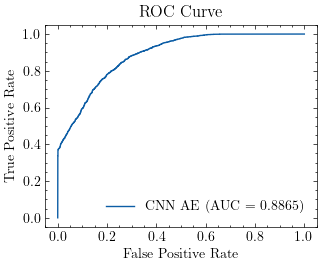

In [12]:
def plot_comparative_roc(results):
    """Plot ROC curve for CNN model"""
    for model_name, metrics in results.items():
        plt.plot(metrics['fpr'], metrics['tpr'],
                 label=f'{model_name} (AUC = {metrics["roc_auc"]:.4f})')

    # plt.plot([0, 1], [0, 1], color='navy', lw=2,
            #  linestyle='--', label='Random Guess')
    # plt.xlim([-0.01, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    # plt.grid(True)
    plt.show()

plot_comparative_roc({'CNN AE': result})

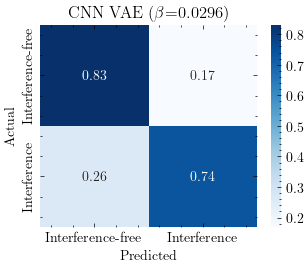

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comparative_confusion_matrices(results, normalize=True):
    """Plot normalized confusion matrices for CNN model."""
    for model_name, metrics in results.items():
        cm = metrics['confusion_matrix']
        
        if normalize:
            cm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)  # Normalize by row (true class)

        sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap='Blues',
                    xticklabels=['Interference-free', 'Interference'],
                    yticklabels=['Interference-free', 'Interference'])

        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'{model_name} ($\\beta$={metrics["threshold"]:.4f})')
        plt.show()

# Example usage:
plot_comparative_confusion_matrices({'CNN VAE': result})
